In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict 

In [2]:
with open('coffee_words.pickle','rb') as read_file:
    coffee = pickle.load(read_file)
with open('coffee_ratings.pickle','rb') as read_file:
    ratings = pickle.load(read_file)

In [3]:
coffee.head()

Roaster  \
0             Jackrabbit Java   
1             Jackrabbit Java   
2  Red Rooster Coffee Roaster   
3           Paradise Roasters   
4               Kakalove Cafe   

                                              Review  \
0  Yeasty, richly sweet-savory. Fresh-baked bread...   
1  Balanced, sweet-toned, floral. Tea rose, cocoa...   
2  Delicate, deep; complex. Pomegranate, macadami...   
3  Very sweet, floral-toned. Freesia, pink grapef...   
4  Opulent, richly sweet-tart-savory. Black curra...   

                                               Notes  \
0  Processed by the anaerobic natural method (who...   
1  Produced at Mahembe Farm and processed at the ...   
2  This coffee earned the highest rating in a cup...   
3  This coffee tied for the second-highest rating...   
4  This coffee tied for the second-highest rating...   

                                                TLDR  
0  An anaerobically processed coffee with rich st...  
1  A friendly, classic Rwanda cup: balanced, deep...  
2  An intricately original natural-processed Colo...  
3  A sweetly evocative presentation of Colombia P...  
4  A rich, complex, decadently sweet cup processe...

In [126]:
ratings = ratings.reset_index().rename(columns={'index':'Roaster'})
ratings.head()

Roaster Overall        Roaster Location  \
0             Jackrabbit Java      93    Thermopolis, Wyoming   
1             Jackrabbit Java      92    Thermopolis, Wyoming   
2  Red Rooster Coffee Roaster      96         Floyd, Virginia   
3           Paradise Roasters      95  Minneapolis, Minnesota   
4               Kakalove Cafe      95         Chia-Yi, Taiwan   

                                       Coffee Origin   Roast Level Agtron  \
0                                         Costa Rica  Medium-Light  54/72   
1                        Nyamasheke District, Rwanda  Medium-Light  58/76   
2  Los Naranjos, La Argentina, Huila Department, ...         Light  64/84   
3                                    Huila, Colombia         Light  62/80   
4                     Antioquia Department, Colombia  Medium-Light  60/80   

         Est. Price    Review Date Aroma Body Flavor Aftertaste Acidity  
0  $20.00/12 ounces  February 2021     9    9      9          8       8  
1  $20.00/12 ounces  February 2021     9    8      9          8       8  
2   $18.99/8 ounces  February 2021     9    9     10          9       9  
3   $16.95/6 ounces  February 2021     9    9      9          9       9  
4  NT $310/8 ounces  February 2021     9    9      9          9       9

In [5]:
import nltk
# nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ejfel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ejfel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
train = coffee

## Combine the review, notes, and summary columns of the review into one note. Remove any websites and the common final sentence about phone numbers or visiting Facebook

In [9]:
df = pd.DataFrame()
df['Roaster'] = train['Roaster']
df['TextA'] = train.Review + train.Notes + train.TLDR
# for ind in range(len(df)):   
# df['TextA'] = re.sub('[^ ]+\.[^ ]+','',df.Total.str)
# df['TextB'] = re.sub(r'Visit.*\n?','',df.TextA.str)
df['TextB'] = df.TextA.str.replace('[^ ]+\.[^ ]+','',regex=True)
df['Text'] = df.TextB.str.replace(r'Visit.*\n?','',regex=True)
df.drop(columns=['TextA','TextB'],inplace=True)
df

Roaster  \
0                Jackrabbit Java   
1                Jackrabbit Java   
2     Red Rooster Coffee Roaster   
3              Paradise Roasters   
4                  Kakalove Cafe   
...                          ...   
5954          The Coffee Beanery   
5955            Starbucks Coffee   
5956             Peerless Coffee   
5957                     Gevalia   
5958                 Café Godiva   

                                                   Text  
0     Yeasty, richly sweet-savory. Fresh-baked bread...  
1     Balanced, sweet-toned, floral. Tea rose, cocoa...  
2     Delicate, deep; complex. Pomegranate, macadami...  
3     Very sweet, floral-toned. Freesia, pink grapef...  
4     Opulent, richly sweet-tart-savory. Black curra...  
...                                                 ...  
5954  A light-medium-roasted blend with power: The a...  
5955  The rest of the taste profile plays peek-a-boo...  
5956  Given the medium roast, the carbon notes here ...  
5957  For such a relatively light roast, not particu...  
5958  This coffee arrived pre-ground (not available ...  

[5959 rows x 2 columns]

In [ ]:
df.Text[4220]

In [10]:
def preprocess_textstem(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    
     # Lowercase and stem
    stemmer = LancasterStemmer()
    stems = [stemmer.stem(token.lower()) for token in tokens]
    
    # Remove stopwords
    keywords= [stem for stem in stems if stem not in stopwords.words('english')]
    return keywords

In [11]:
# def preprocess_textchunks(text):
#     # Remove numbers
#     text = re.sub(r'\d+', '', text)
    
#     # Tokenise words while ignoring punctuation
#     tokeniser = RegexpTokenizer(r'\w+')
#     tokens = tokeniser.tokenize(text)
    
#      # Lowercase and stem
#     stemmer = LancasterStemmer()
#     stems = [stemmer.stem(token.lower()) for token in tokens]
    
#     # Remove stopwords
#     keywords= [stem for stem in stems if stem not in stopwords.words('english')]
#     return keywords

In [12]:
def preprocess_textlemma(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    return keywords

In [15]:
# # Create an instance of TfidfVectorizer
# vectoriser = TfidfVectorizer(analyzer=preprocess_textstem)
# # Fit to the data and transform to feature matrix
# stem_X = vectoriser.fit_transform(train.Review)
# # Convert sparse matrix to dataframe
# stem_X = pd.DataFrame.sparse.from_spmatrix(stem_X)
# # Save mapping on which index refers to which words
# col_map = {v:k for k, v in vectoriser.vocabulary_.items()}
# # Rename each column using the mapping
# for col in stem_X.columns:
#     stem_X.rename(columns={col: col_map[col]}, inplace=True)
# stem_X

# # Create an instance of TfidfVectorizer
# vectoriser = TfidfVectorizer(analyzer=preprocess_textlemma)
# # Fit to the data and transform to feature matrix
# lemma_X = vectoriser.fit_transform(df['Text'])
# # Convert sparse matrix to dataframe
# lemma_X = pd.DataFrame.sparse.from_spmatrix(lemma_X)
# # Save mapping on which index refers to which words
# col_map = {v:k for k, v in vectoriser.vocabulary_.items()}
# # Rename each column using the mapping
# for col in lemma_X.columns:
#     lemma_X.rename(columns={col: col_map[col]}, inplace=True)
# lemma_X
df.Text.head()

0    Yeasty, richly sweet-savory. Fresh-baked bread...
1    Balanced, sweet-toned, floral. Tea rose, cocoa...
2    Delicate, deep; complex. Pomegranate, macadami...
3    Very sweet, floral-toned. Freesia, pink grapef...
4    Opulent, richly sweet-tart-savory. Black curra...
Name: Text, dtype: object

In [16]:
# Create an instance of TfidfVectorizer
sample_vector = TfidfVectorizer(analyzer=preprocess_textlemma)
# Fit to the data and transform to feature matrix
sample_lemma = sample_vector.fit_transform(df.Text.head())
# Convert sparse matrix to dataframe
sample_lemma = pd.DataFrame.sparse.from_spmatrix(sample_lemma)
# Save mapping on which index refers to which words
col_map = {v:k for k, v in sample_vector.vocabulary_.items()}
# Rename each column using the mapping
for col in sample_lemma.columns:
    sample_lemma.rename(columns={col: col_map[col]}, inplace=True)
sample_lemma

achicue   acidity     add   agave       air  alliance    almond  \
0  0.000000  0.000000  0.0000  0.0000  0.113155  0.000000  0.000000   
1  0.000000  0.078101  0.0000  0.0000  0.111844  0.000000  0.277256   
2  0.000000  0.071212  0.1264  0.1264  0.000000  0.000000  0.000000   
3  0.122191  0.068840  0.0000  0.0000  0.000000  0.000000  0.000000   
4  0.000000  0.068777  0.0000  0.0000  0.000000  0.122078  0.000000   

   anaerobic   arabica     aroma    around      asia      bake   balance  \
0   0.113155  0.000000  0.066831  0.093929  0.000000  0.420757  0.000000   
1   0.000000  0.000000  0.066057  0.092841  0.000000  0.000000  0.185681   
2   0.000000  0.084652  0.120461  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.163665  0.058225  0.081833  0.122191  0.000000  0.081833   
4   0.098492  0.081757  0.058171  0.000000  0.000000  0.000000  0.081757   

      batch     black   blossom   bourbon     bread      café     candy  \
0  0.000000  0.000000  0.000000  0.000000  0.140252  0.000000  0.140252   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.122191  0.000000  0.000000  0.122191  0.000000  0.000000  0.000000   
4  0.000000  0.122078  0.122078  0.000000  0.000000  0.122078  0.000000   

    caturra    caucho     cedar    center   certify    cherry      chia  \
0  0.000000  0.000000  0.113155  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.101979  0.000000  0.000000  0.000000  0.101979  0.000000  0.000000   
3  0.000000  0.122191  0.000000  0.122191  0.000000  0.000000  0.000000   
4  0.098492  0.000000  0.098492  0.000000  0.098492  0.122078  0.122078   

   chocolate  chocolaty  cinnamon      city     cocoa    coffee   coffees  \
0   0.226309   0.000000  0.280504  0.000000  0.000000  0.000000  0.133662   
1   0.000000   0.000000  0.000000  0.000000  0.138628  0.000000  0.132114   
2   0.000000   0.000000  0.000000  0.000000  0.000000  0.253955  0.060230   
3   0.000000   0.000000  0.000000  0.000000  0.000000  0.163665  0.174674   
4   0.098492   0.122078  0.000000  0.122078  0.000000  0.327028  0.058171   

   colombia   company  complex  conscious  consolidate     craft       cup  \
0  0.000000  0.000000   0.0000     0.0000     0.140252  0.000000  0.066831   
1  0.000000  0.000000   0.0000     0.0000     0.000000  0.000000  0.066057   
2  0.169303  0.000000   0.1264     0.1264     0.000000  0.000000  0.180691   
3  0.081833  0.122191   0.0000     0.0000     0.000000  0.122191  0.116449   
4  0.163514  0.000000   0.0000     0.0000     0.000000  0.000000  0.116342   

    currant       cut      dark    deep    deeply  delicate    dill       dry  \
0  0.000000  0.140252  0.000000  0.0000  0.000000    0.0000  0.0000  0.066831   
1  0.000000  0.000000  0.000000  0.0000  0.000000    0.0000  0.0000  0.066057   
2  0.000000  0.000000  0.000000  0.1264  0.000000    0.1264  0.1264  0.060230   
3  0.000000  0.000000  0.000000  0.0000  0.000000    0.0000  0.0000  0.058225   
4  0.122078  0.000000  0.122078  0.0000  0.122078    0.0000  0.0000  0.058171   

     earn        el   elegant    emerge  entirely  establish      farm  \
0  0.0000  0.000000  0.000000  0.000000  0.000000     0.0000  0.000000   
1  0.0000  0.000000  0.000000  0.000000  0.000000     0.0000  0.078101   
2  0.1264  0.000000  0.000000  0.000000  0.000000     0.1264  0.071212   
3  0.0000  0.122191  0.000000  0.122191  0.098583     0.0000  0.068840   
4  0.0000  0.000000  0.122078  0.000000  0.098492     0.0000  0.068777   

   february  fermentation     finca    finest    finish    flavor     flesh  \
0  0.000000      0.113155  0.000000  0.093929  0.079016  0.000000  0.000000   
1  0.000000      0.000000  0.000000  0.092841  0.078101  0.000000  0.111844   
2  0.084652      0.000000  0.000000  0.000000  0.071212  0.101979  0.000000   
3  0.081833      0.000000  0.098583  0

In [18]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer=preprocess_textlemma)
# Fit to the data and transform to feature matrix
lemmas = vectorizer.fit_transform(df.Text)
# Convert sparse matrix to dataframe
lemmas = pd.DataFrame.sparse.from_spmatrix(lemmas)
# Save mapping on which index refers to which words
col_map = {v:k for k, v in vectorizer.vocabulary_.items()}
# Rename each column using the mapping
for col in lemmas.columns:
    lemmas.rename(columns={col: col_map[col]}, inplace=True)
lemmas

aa  aaa  aaanyone  aaseattle  aayou   ab  ababa  abad  abafita  \
0     0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   
1     0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   
2     0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   
3     0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   
4     0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   
...   ...  ...       ...        ...    ...  ...    ...   ...      ...   
5954  0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   
5955  0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   
5956  0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   
5957  0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   
5958  0.0  0.0       0.0        0.0    0.0  0.0    0.0   0.0      0.0   

      abakundakawa  abandon  abaryoshyakawa  abay  abbey  abbreviation  \
0              0.0      0.0             0.0   0.0    0.0           0.0   
1              0.0      0.0             0.0   0.0    0.0           0.0   
2              0.0      0.0             0.0   0.0    0.0           0.0   
3              0.0      0.0             0.0   0.0    0.0           0.0   
4              0.0      0.0             0.0   0.0    0.0           0.0   
...            ...      ...             ...   ...    ...           ...   
5954           0.0      0.0             0.0   0.0    0.0           0.0   
5955           0.0      0.0             0.0   0.0    0.0           0.0   
5956           0.0      0.0             0.0   0.0    0.0           0.0   
5957           0.0      0.0             0.0   0.0    0.0           0.0   
5958           0.0      0.0             0.0   0.0    0.0           0.0   

      abdullah  aberdare  abet  ability  able  abregado  abril  abroad  \
0          0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   
1          0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   
2          0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   
3          0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   
4          0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   
...        ...       ...   ...      ...   ...       ...    ...     ...   
5954       0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   
5955       0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   
5956       0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   
5957       0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   
5958       0.0       0.0   0.0      0.0   0.0       0.0    0.0     0.0   

      abruptly  absence  absent  absolute  absolutely  absorb  absorbingly  \
0          0.0      0.0     0.0       0.0         0.0     0.0          0.0   
1          0.0      0.0     0.0       0.0         0.0     0.0          0.0   
2          0.0      0.0     0.0       0.0         0.0     0.0          0.0   
3          0.0      0.0     0.0       0.0         0.0     0.0          0.0   
4          0.0      0.0     0.0       0.0         0.0     0.0          0.0   
...        ...      ...     ...       ...         ...     ...          ...   
5954       0.0      0.0     0.0       0.0         0.0     0.0          0.0   
5955       0.0      0.0     0.0       0.0         0.0     0.0          0.0   
5956       0.0      0.0     0.0       0.0         0.0     0.0          0.0   
5957       0.0      0.0     0.0       0.0         0.0     0.0          0.0   
5958       0.0      0.0     0.0       0.0         0.0     0.0          0.0   

      abstract  abstractly  abu  abundancia  abundant  abundantly  abuse  \
0          0.0         0.0  0.0         0.0       0.0         0.0    0.0   
1          0.0         0.0  0.0         0.0       0.0         0.0    0.0   
2          0.0         0.0  0.0         0.0       0.0         0.0    0.0   
3          0.0         0.0  0.0         0.0       0.0         0.0    0.0   
4          0.0         0.0  0.0    

In [19]:
with open('corpus_lemmas.pickle', 'wb') as to_write:
    pickle.dump(lemmas, to_write)

In [20]:
lemmas.shape

(5959, 11026)

In [ ]:
with open('reviews_stemmed.pickle', 'wb') as to_write:
    pickle.dump(stem_X, to_write)

In [ ]:
with open('reviews_lemma.pickle', 'wb') as to_write:
    pickle.dump(lemma_X, to_write)

In [ ]:
with open('reviews_stemmed.pickle','rb') as read_file:
    reviews_stemmed = pickle.load(read_file)

In [ ]:
with open('reviews_lemma.pickle','rb') as read_file:
    reviews_lemma = pickle.load(read_file)

In [63]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [304]:
vectorizer = CountVectorizer(min_df=10, stop_words = 'english',max_df=3200)
doc_word = vectorizer.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
pd.DataFrame(doc_word.toarray(), index=df.index, columns=vectorizer.get_feature_names()).head(10)

tldrvectorizer = CountVectorizer(min_df=10, stop_words = 'english',max_df=1200)
tldr_word = tldrvectorizer.fit_transform(coffee.TLDR.str.replace(r'\d+','',regex=True))
pd.DataFrame(tldr_word.toarray(), index=coffee.index, columns=tldrvectorizer.get_feature_names()).head(10)

accessible  acid  acidity  acidy  add  admire  admired  admirers  \
0           0     0        0      0    0       0        0         0   
1           0     0        0      0    0       0        0         0   
2           0     0        0      0    0       0        0         0   
3           0     0        0      0    0       0        0         0   
4           0     0        0      0    0       0        0         0   
5           0     0        0      0    0       0        0         0   
6           0     0        1      0    0       0        0         0   
7           0     0        0      0    0       0        0         0   
8           0     0        0      0    0       0        0         0   
9           0     0        0      0    0       0        0         0   

   adventurers  afford  aficionado  aficionados  africa  african  afternoon  \
0            0       0           0            0       0        0          0   
1            0       0           0            0       0        0          0   
2            0       0           0            0       0        0          0   
3            0       0           0            0       0        0          0   
4            0       0           0            0       0        0          0   
5            0       0           0            0       0        0          0   
6            0       0           0            0       0        0          0   
7            0       0           0            0       0        0          0   
8            0       0           0            0       0        0          0   
9            0       0           0            0       0        0          0   

   aggressive  agreeable  alive  amazing  america  american  anaerobic  \
0           0          0      0        0        0         0          0   
1           0          0      0        0        0         0          0   
2           0          0      0        0        0         0          0   
3           0          0      0        0        0         0          0   
4           0          0      0        0        0         0          1   
5           0          0      0        0        0         0          0   
6           0          0      0        0        0         0          0   
7           0          0      0        0        0         0          1   
8           0          0      0        0        0         0          0   
9           0          0      0        0        0         0          0   

   animated  antigua  appeal  appealing  apple  appreciate  arabica  aroma  \
0         0        0       0          0      0           0        0      0   
1         0        0       0          0      0           0        0      0   
2         0        0       0          0      0           0        0      0   
3         0        0       0          0      0           0        0      0   
4         0        0       0          0      0           0        0      0   
5         0        0       0          0      0           0        0      0   
6         0        0       0          0      0           0        0      0   
7         0        0       0          0      0           0        0      0   
8         0        0       0          0      0           0        0      0   
9         0        0       0          0      0           0        0      0   

   aromatic  aromatically  aromatics  assertive  associate  associated  \
0         0             0          1          0          0           0   
1         0             0          0          0          0           0   
2         0             0          0          0          0           0   
3         0             0          0          0          0           1   
4         0             0          0          0          0           0   
5         0             0          0          0          0           0   
6         0             0          0          0          0           0   
7         0             0          0          0          0           0   
8         0

In [231]:
tldr_word.shape

(5959, 474)

In [239]:
tldrvectorizer1000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=1000)
tldrvectorizer1000.fit_transform(coffee.TLDR.str.replace(r'\d+','',regex=True))
tldrvectorizer1200 = CountVectorizer(min_df=20, stop_words = 'english',max_df=1200)
tldrvectorizer1200.fit_transform(coffee.TLDR.str.replace(r'\d+','',regex=True))
tldrvectorizer3000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=3000)
tldrvectorizer3000.fit_transform(coffee.TLDR.str.replace(r'\d+','',regex=True))

<5959x478 sparse matrix of type '<class 'numpy.int64'>'
	with 48512 stored elements in Compressed Sparse Row format>

In [303]:
totalvectorizer1000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=1000)
totalvectorizer1000.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
totalvectorizer2000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=2000)
totalvectorizer2000.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
totalvectorizer5000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=5000)
totalvectorizer5000.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
totalvectorizer3200 = CountVectorizer(min_df=20, stop_words = 'english',max_df=3200)
totalvectorizer3200.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
set(totalvectorizer3200.get_feature_names()).symmetric_difference(totalvectorizer5000.get_feature_names())

{'acidity', 'aroma', 'coffees', 'finish', 'fruit', 'mouthfeel', 'sweet'}

In [293]:
set(tldrvectorizer1000.get_feature_names()).symmetric_difference(tldrvectorizer3000.get_feature_names())

{'coffee', 'cup', 'fruit', 'sweet'}

In [36]:
from sklearn.decomposition import NMF

## NMF on TLDR
min_df=20, max_df=1000 with 7 or 8 topics starts getting what seem to be real profiles
Reducing max_df from 3000 to 1000 only eliminates 4 words from corpus (coffee, cup, fruit, sweet)
3000 to 1500 only removes cup, to 1200 removes coffee and cup

In [242]:
nmf_tldr2 = NMF(2)
tldrdoc_topic2 = nmf_tldr2.fit_transform(tldr_word)
tldrtopic_word2 = pd.DataFrame(nmf_tldr2.components_.round(3),
             index = ["component_1","component_2"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr2, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, sweet, notes, toned, floral, natural, processed, ethiopia, chocolate, rich

Topic  1
enjoy, espresso, dark, milk, roast, roasted, complex, chocolate, straight, shot


In [243]:
nmf_tldr3 = NMF(3)
tldrdoc_topic3 = nmf_tldr3.fit_transform(tldr_word)
tldrtopic_word3 = pd.DataFrame(nmf_tldr3.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr3, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, notes, natural, processed, toned, ethiopia, floral, dried, chocolate, rich

Topic  1
enjoy, espresso, dark, milk, roast, roasted, complex, chocolate, straight, shot

Topic  2
sweet, toned, notes, floral, savory, kenya, classic, tart, rich, deeply


In [244]:
nmf_tldr4 = NMF(4)
tldrdoc_topic4 = nmf_tldr4.fit_transform(tldr_word)
tldrtopic_word4 = pd.DataFrame(nmf_tldr4.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr4, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, notes, processed, toned, ethiopia, floral, dried, chocolate, rich

Topic  1
enjoy, dark, roast, roasted, coffees, classic, lovers, complex, acidity, style

Topic  2
sweet, toned, notes, floral, savory, kenya, classic, tart, rich, balanced

Topic  3
espresso, milk, straight, shot, blend, complex, short, chocolate, balanced, cappuccino


In [245]:
nmf_tldr5 = NMF(5)
tldrdoc_topic5 = nmf_tldr5.fit_transform(tldr_word)
tldrtopic_word5 = pd.DataFrame(nmf_tldr5.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr5, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, notes, processed, toned, ethiopia, floral, dried, chocolate, rich

Topic  1
enjoy, classic, complex, coffees, acidity, kenya, dry, sweetness, style, profile

Topic  2
sweet, toned, notes, floral, savory, kenya, tart, classic, rich, deeply

Topic  3
espresso, milk, straight, shot, blend, short, complex, balanced, cappuccino, chocolate

Topic  4
dark, roast, chocolate, roasted, medium, coffees, blend, darker, lovers, like


In [246]:
nmf_tldr6 = NMF(6)
tldrdoc_topic6 = nmf_tldr6.fit_transform(tldr_word)
tldrtopic_word6 = pd.DataFrame(nmf_tldr6.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr6, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, processed, dried, ethiopia, notes, like, stone, flowers, forward

Topic  1
enjoy, classic, complex, coffees, kenya, acidity, dry, sweetness, style, profile

Topic  2
sweet, savory, tart, kenya, deeply, classic, richly, notes, crisply, tones

Topic  3
espresso, milk, straight, shot, complex, blend, short, balanced, cappuccino, single

Topic  4
dark, roast, roasted, chocolate, medium, coffees, blend, lovers, character, darker

Topic  5
toned, floral, notes, chocolate, rich, deep, spice, cocoa, high, nut


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [247]:
nmf_tldr7 = NMF(7)
tldrdoc_topic7 = nmf_tldr7.fit_transform(tldr_word)
tldrtopic_word7 = pd.DataFrame(nmf_tldr7.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr7, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, processed, dried, ethiopia, like, notes, stone, forward, flowers

Topic  1
enjoy, coffees, dry, wines, complex, sweetness, roasted, table, style, beverages

Topic  2
sweet, savory, tart, deeply, richly, notes, crisply, tones, like, ferment

Topic  3
espresso, milk, straight, shot, blend, short, complex, cappuccino, single, origin

Topic  4
dark, roast, roasted, chocolate, medium, coffees, blend, lovers, like, character

Topic  5
toned, floral, notes, chocolate, rich, deep, spice, cocoa, high, nut

Topic  6
classic, kenya, balanced, profile, bright, complex, acidity, version, juicy, great


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [248]:
nmf_tldr8 = NMF(8)
tldrdoc_topic8 = nmf_tldr8.fit_transform(tldr_word)
tldrtopic_word8 = pd.DataFrame(nmf_tldr8.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr8, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, processed, dried, ethiopia, like, forward, flowers, stone, ferment

Topic  1
enjoy, coffees, dry, wines, complex, sweetness, table, roasted, beverages, style

Topic  2
sweet, savory, tart, deeply, richly, crisply, tones, ferment, blend, flowers

Topic  3
espresso, milk, straight, shot, blend, short, complex, cappuccino, single, origin

Topic  4
dark, roast, roasted, chocolate, medium, coffees, blend, lovers, character, good

Topic  5
toned, floral, high, spice, cocoa, nut, sweetly, low, rich, deep

Topic  6
classic, kenya, balanced, profile, bright, complex, acidity, version, juicy, great

Topic  7
notes, floral, chocolate, rich, aromatic, wood, deep, citrus, florals, cocoa


## NMF with two topics. 
### We begin to see more common terms of robust notes chocolate, rich, dark, roast in the first topic
### We see more delicate terms in the second like fruit, floral, ethiopia, washed

In [305]:
nmf_model2 = NMF(2)
doc_topic2 = nmf_model2.fit_transform(doc_word)

In [306]:
topic_word = pd.DataFrame(nmf_model2.components_.round(3),
             index = ["component_1","component_2"],
             columns = vectorizer.get_feature_names())
topic_word.sort_values(by='component_1',axis=1,ascending=False)

processed  toned    wet  beans  floral  washed  arabica   like  \
component_1      4.602  3.176  2.763  2.504   2.478   2.461    2.458  2.440   
component_2      0.000  2.034  0.000  0.331   0.542   0.000    0.167  0.683   

             ethiopia  removed  dried  region  drying  notes  produced  \
component_1     2.421     2.38  2.311   2.047   1.948  1.890     1.854   
component_2     0.000     0.00  0.003   0.000   0.385  1.952     0.440   

             method   long  natural  varieties  roaster  meaning    dry  \
component_1   1.781  1.729    1.719      1.651    1.606    1.549  1.548   
component_2   0.016  0.472    0.000      0.000    1.157    0.493  0.634   

             grown   skin   tart  structure  variety  cocoa  small  quality  \
component_1  1.544  1.503  1.502      1.460    1.429  1.401  1.366    1.283   
component_2  0.676  0.000  0.470      0.068    0.755  0.265  2.533    0.792   

             flavor   pulp  crisp  distinctive  yirgacheffe  sweetly    nib  \
component_1   1.257  1.255  1.223        1.208        1.192    1.186  1.167   
component_2   1.011  0.000  0.522        0.196        0.000    0.523  0.000   

             inside  southern  richly  traditional  roasting  roasted  syrupy  \
component_1   1.157     1.147   1.137        1.120     1.110    1.081   1.078   
component_2   0.000     0.000   0.526        0.045     1.471    0.804   0.979   

             honey  flowers  trees  gesha  juicy  case  review  cacao  \
component_1  1.046    1.034  1.015  0.993  0.930  0.91   0.896  0.893   
component_2  0.218    1.312  0.355  0.000  0.053  0.00   0.084  0.000   

             tasting  based  particular   rich   zest  aromatic  citrus  \
component_1    0.825  0.811       0.808  0.791  0.784     0.775   0.775   
component_2    0.037  0.711       0.127  1.651  0.155     0.422   0.380   

             resonant  savory   high  version  bright  produces  world  \
component_1     0.755   0.755  0.752    0.749   0.733     0.722  0.700   
component_2     0.329   0.288  0.365    0.000   0.310     0.016  0.586   

             highest  deeply  delicate  satiny  great  fresh  consolidates  \
component_1    0.695   0.691     0.687   0.663  0.652  0.636         0.623   
component_2    0.171   0.282     0.376   0.069  0.000  0.657         0.121   

             rating  balanced  saturated  crisply  report  lemon  sandalwood  \
component_1   0.618     0.616      0.605    0.604   0.600  0.591        0.59   
component_2   0.081     0.998      0.196    0.194   0.011  0.340        0.00   

             profile  silky  complex  micro  almond  company   tied  \
component_1    0.580  0.574    0.564  0.562   0.551    0.547  0.544   
component_2    0.294  0.372    0.769  0.140   0.152    0.851  0.015   

             complexity  roasters  bourbon  smooth  entirely  short  \
component_1       0.542     0.541    0.539   0.538     0.537  0.534   
component_2       0.128     1.326    0.334   0.461     0.253  0.365   

             intensity  lightly   hint  express   food  lively  typically  \
component_1      0.523    0.522  0.519    0.514  0.514   0.511      0.508   
component_2      0.000    0.669  1.036    0.000  0.026   0.200      0.000   

             growing  ethiopian  chocolate  geisha  gently  specialty  plots  \
component_1    0.499      0.497      0.494   0.491   0.475      0.472  0.471   
component_2    0.509      0.000      5.640   0.000   0.643      1.141  0.000   

             villagers  garden  subsistence  interplanted  unique  emphasis  \
component_1      0.467   0.465        0.464         0.462   0.458     0.452   
component_2      0.000   0.000        0.000         0.000   0.030     0.000   

             crops  sourcing  black  located  virtually  organic    lot  \
component_1  0.452     0.434  0.428    0.428      0.427    0.421  0.418   
component_2  0.000     0.157  0.480    0.361      0.000    0.264  0.195   

             orange  cedar  farmers   farm   deep  taiwan  cupping  jasmine  \
component_1   0.4

In [252]:
display_topics(nmf_model2, vectorizer.get_feature_names(), 10)


Topic  0
processed, wet, beans, washed, like, arabica, ethiopia, removed, floral, dried

Topic  1
small, notes, dark, rich, roast, single, espresso, fair, roasters, roasting


## For NMF with three topics
### First category is focused on acid, sweetness, mouthfeel
### Second is processes and fruit
### Third is chocolate, espresso, heavier roast

In [307]:
nmf_model3 = NMF(3)
doc_topic3 = nmf_model3.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model3.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model3, vectorizer.get_feature_names(), 10)


Topic  0
processed, toned, wet, floral, washed, beans, ethiopia, like, arabica, removed

Topic  1
chocolate, dark, espresso, small, toned, notes, milk, roasting, rich, cedar

Topic  2
fair, brewing, keurig, green, roasters, single, certified, mountain, serve, trade


## Four topics NMF
### First is sweetness, acidity, mouthfeel aroma (categories for scores?)
### Second is processing (fruit, wet, washed, dried, removed)
### Third is dark roast character
### Fourth is about the roaster/brewing process?

In [308]:
nmf_model4 = NMF(4)
doc_topic4 = nmf_model4.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model4.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model4, vectorizer.get_feature_names(), 10)


Topic  0
processed, ethiopia, like, region, floral, toned, grown, wet, long, yirgacheffe

Topic  1
chocolate, dark, espresso, small, milk, toned, notes, cedar, rich, roasting

Topic  2
brewing, fair, keurig, green, single, roasters, mountain, serve, certified, trade

Topic  3
beans, processed, variety, arabica, toned, trees, tart, gesha, structure, dried


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## NMF with 5
### 1 = Overall categories of coffee scoring
### 2 = Focus on origin, processing (a little lighter roast/africa)
### 3 = Dark roast characteristics
### 4 = Brewing process and roaster info
### 5 = Fruit character and processing

In [309]:
nmf_model5 = NMF(5)
doc_topic5 = nmf_model5.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model5.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model5, vectorizer.get_feature_names(), 10)


Topic  0
like, floral, region, ethiopia, notes, long, grown, toned, yirgacheffe, drying

Topic  1
chocolate, dark, espresso, small, milk, toned, notes, cedar, blend, rich

Topic  2
fair, brewing, keurig, green, roasters, single, mountain, certified, serve, trade

Topic  3
world, variety, kenya, trees, produce, flowers, roasting, tart, bean, beans

Topic  4
processed, dried, beans, natural, wet, dry, removed, washed, meaning, toned


## NMF with 6
### 1 = Sweetness, mouthfeel, acidity
### 2 = Flavor, lighter notes
### 3 = Dark roast characteristics
### 4 = Info on sourcing and ethics
### 5 = Processing focus
### 6 = Brewing methods, roaster info

In [310]:
nmf_model6 = NMF(6)
doc_topic6 = nmf_model6.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model6.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model6, vectorizer.get_feature_names(), 10)


Topic  0
like, floral, region, ethiopia, notes, long, toned, yirgacheffe, drying, grown

Topic  1
chocolate, dark, espresso, small, milk, toned, notes, cedar, blend, rich

Topic  2
brewing, keurig, single, green, serve, mountain, roasters, capsule, roast, variety

Topic  3
kenya, world, variety, produce, trees, flowers, roasting, bean, tart, distinctive

Topic  4
processed, dried, beans, natural, wet, dry, removed, washed, meaning, toned

Topic  5
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## NMF with 7
### 1 = Reviews, ratings, scores, categories
### 2 = Uniqueness of sourcing, specialness of bean (kenya, gesha)
### 3 = Dark roast characteristics
### 4 = (Ethiopia, Yirgacheffe)
### 5 = Processing focus
### 6 = Brewing methods, roaster info
### 7 = Specific tasting notes

In [311]:
nmf_model7 = NMF(7)
doc_topic7 = nmf_model7.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model7.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model7, vectorizer.get_feature_names(), 10)


Topic  0
like, floral, region, ethiopia, notes, long, yirgacheffe, grown, southern, toned

Topic  1
chocolate, dark, espresso, small, milk, toned, notes, cedar, blend, rich

Topic  2
brewing, keurig, green, single, serve, mountain, roasters, capsule, roast, variety

Topic  3
toned, arabica, structure, cocoa, tart, variety, method, drying, trees, review

Topic  4
processed, dried, beans, natural, dry, meaning, wet, inside, removed, case

Topic  5
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding

Topic  6
kenya, world, produce, bean, beans, distinctive, elegant, flowers, peaberries, flavor


## NMF with 8
### 1 = Sweetness, mouthfeel, acidity
### 2 = Flavor, lighter notes
### 3 = Dark roast characteristics
### 4 = Info on sourcing and ethics
### 5 = Processing focus
### 6 = Brewing methods, roaster info

In [312]:
nmf_model8 = NMF(8)
doc_topic8 = nmf_model8.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model8.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model8, vectorizer.get_feature_names(), 10)


Topic  0
like, ethiopia, region, floral, long, yirgacheffe, southern, drying, grown, varieties

Topic  1
chocolate, espresso, dark, milk, small, cedar, evaluated, parts, blend, syrupy

Topic  2
brewing, keurig, single, green, serve, mountain, roasters, capsule, variety, roast

Topic  3
arabica, structure, toned, variety, tart, cocoa, method, trees, drying, washed

Topic  4
processed, dried, beans, natural, dry, meaning, wet, inside, case, removed

Topic  5
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding

Topic  6
kenya, produce, world, bean, beans, distinctive, elegant, peaberries, flowers, sl

Topic  7
toned, notes, floral, rich, roast, sweetness, roasting, body, roaster, tones


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


### First is overall quality, exceptionalism
### Second is processing
### Third Dark roast charactistics
### Fourth Ethiopia (Yigracheffe)
### Fifth is ethics, fair trade, etc
### Sixth is brewing methods
### Seventh is flavor descriptors
### Eighth is Geisha, worldly?
### Ninth is Kenya, distinction, nuance
### Tenth is flavor descriptions

In [313]:
nmf_model10 = NMF(10)
doc_topic10 = nmf_model10.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model10.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9","component_10"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model10, vectorizer.get_feature_names(), 10)


Topic  0
like, ethiopia, region, floral, long, yirgacheffe, southern, grown, drying, varieties

Topic  1
chocolate, espresso, dark, milk, small, cedar, evaluated, parts, blend, syrupy

Topic  2
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding

Topic  3
brewing, keurig, single, green, serve, mountain, roasters, capsule, roast, variety

Topic  4
processed, dried, natural, dry, beans, meaning, inside, wet, case, removed

Topic  5
arabica, structure, toned, tart, cocoa, method, washed, processed, drying, review

Topic  6
beans, bean, peaberries, single, produce, flat, different, crop, usual, develops

Topic  7
toned, notes, rich, floral, roasting, roast, sweetness, roaster, body, roasted

Topic  8
gesha, variety, floral, world, geisha, beans, trees, continues, crisp, unique

Topic  9
kenya, world, distinctive, elegant, produce, sl, currant, prime, urban, encroachment


In [314]:
nmf_model9 = NMF(9)
doc_topic9 = nmf_model9.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model9.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model9, vectorizer.get_feature_names(), 10)


Topic  0
like, ethiopia, region, floral, long, yirgacheffe, southern, grown, drying, varieties

Topic  1
chocolate, espresso, dark, milk, small, cedar, evaluated, parts, blend, syrupy

Topic  2
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding

Topic  3
brewing, keurig, single, green, serve, mountain, roasters, capsule, variety, roast

Topic  4
processed, dried, beans, natural, dry, meaning, wet, inside, case, removed

Topic  5
arabica, structure, toned, tart, cocoa, method, washed, drying, processed, review

Topic  6
kenya, produce, bean, beans, world, peaberries, elegant, distinctive, sl, flowers

Topic  7
notes, toned, rich, floral, roast, roasting, sweetness, body, tones, roaster

Topic  8
gesha, variety, floral, world, geisha, beans, trees, continues, crisp, unique


In [315]:
df['Two Topic'] = doc_topic2.argmax(axis=1)
df['Three Topic'] = doc_topic3.argmax(axis=1)
df['Four Topic'] = doc_topic4.argmax(axis=1)
df['Five Topic'] = doc_topic5.argmax(axis=1)
df['Six Topic'] = doc_topic6.argmax(axis=1)
df['Seven Topic'] = doc_topic7.argmax(axis=1)
df['Eight Topic'] = doc_topic8.argmax(axis=1)
df['Ten Topic'] = doc_topic10.argmax(axis=1)
df.sample(3)

Roaster  \
2806            Black Bar Cafe   
5412       Thanksgiving Coffee   
4123  Barefoot Coffee Roasters   

                                                   Text  Topic  Two Topic  \
2806  Evaluated as espresso. Spicy and quite complex...      2          1   
5412  A richly expansive, deeply dimensioned coffee,...      0          1   
4123  Sweet tangerine and jasmine aroma, balanced ac...      1          0   

      Three Topic  Four Topic  Five Topic  Six Topic  Seven Topic  \
2806            1           1           1          1            1   
5412            1           1           3          3            6   
4123            0           0           0          0            0   

      Eight Topic  Ten Topic  
2806            1          1  
5412            7          7  
4123            0          0

In [282]:
# df[df['Ten Topic'] == 6]

In [292]:
df[df['Ten Topic'] == 1].iloc[15].Text

'High-toned, floral and chocolaty. Dark chocolate, narcissus, almond, brown sugar, apricot in aroma and cup. Sweetly tart with bright acidity; satiny-smooth mouthfeel. The finish centers around notes of dark chocolate and  by Roxana Rangel from trees of the Yellow Caturra and Typica varieties of Arabica and processed by the washed method (fruit skin and flesh are removed before drying). JBC Coffee Roasters’ vision is simple: “let the coffee lead the way” through sourcing and roasting the best and most unique coffees available and rewarding the farmers who grow those coffees with substantial premiums. '

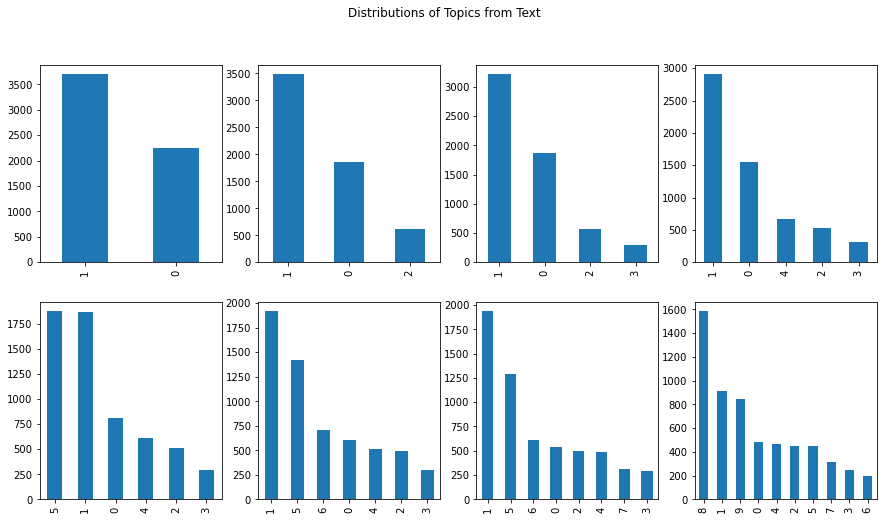

In [263]:
two = df['Two Topic'].value_counts()
three = df['Three Topic'].value_counts()
four = df['Four Topic'].value_counts()
five = df['Five Topic'].value_counts()
six = df['Six Topic'].value_counts()
seven = df['Seven Topic'].value_counts()
eight = df['Eight Topic'].value_counts()
ten = df['Ten Topic'].value_counts()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,8))
fig.suptitle('Distributions of Topics from Text')

two.plot(ax=axes[0,0], kind='bar')
three.plot(ax=axes[0,1], kind='bar')
four.plot(ax=axes[0,2], kind='bar')
five.plot(ax=axes[0,3], kind='bar')
six.plot(ax=axes[1,0], kind='bar')
seven.plot(ax=axes[1,1], kind='bar')
eight.plot(ax=axes[1,2], kind='bar')
ten.plot(ax=axes[1,3], kind='bar')
# ax2 = three.plot(kind='bar')
# ax3 = four.plot(kind='bar')
# ax4 = five.plot(kind='bar')
# ax5 = six.plot(kind='bar')
# ax6 = seven.plot(kind='bar')
# ax7 = eight.plot(kind='bar')
# ax8 = ten.plot(kind='bar')


In [132]:
combined = pd.DataFrame()
combined['roaster'] = df['Roaster']
combined['origin'] = ratings['Coffee Origin']
combined['roast_level'] = ratings['Roast Level']
combined['group'] = df['Three Topic']
combined['rating'] = ratings.Overall
combined['aroma'] = ratings.Aroma
combined['body'] = ratings.Body
combined['flavor'] = ratings.Flavor
combined['aftertaste'] = ratings.Aftertaste
combined['acidity'] = ratings.Acidity
combined.head()

roaster  \
0             Jackrabbit Java   
1             Jackrabbit Java   
2  Red Rooster Coffee Roaster   
3           Paradise Roasters   
4               Kakalove Cafe   

                                              origin   roast_level  group  \
0                                         Costa Rica  Medium-Light      2   
1                        Nyamasheke District, Rwanda  Medium-Light      1   
2  Los Naranjos, La Argentina, Huila Department, ...         Light      1   
3                                    Huila, Colombia         Light      1   
4                     Antioquia Department, Colombia  Medium-Light      0   

  rating aroma body flavor aftertaste acidity  
0     93     9    9      9          8       8  
1     92     9    8      9          8       8  
2     96     9    9     10          9       9  
3     95     9    9      9          9       9  
4     95     9    9      9          9       9

In [152]:
combined.loc[combined.rating == 'NR','rating'] = '-999'

In [154]:
combined.rating = combined.rating.astype(int)

In [155]:
combined[combined.rating>0].groupby(by='group').rating.mean()

group
0    89.789677
1    92.419118
2    89.204091
Name: rating, dtype: float64

In [161]:
combined.loc[(combined.aroma == 'NR')|(combined.aroma == 'NA'),'aroma'] = '-999'
combined.aroma = combined.aroma.astype(float)
combined.aroma = combined.aroma.round(0)
combined[combined.aroma>0].groupby(by='group').aroma.mean()

C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


group
0    8.108440
1    8.720887
2    8.002673
Name: aroma, dtype: float64

In [165]:
combined.loc[(combined.body == 'NR')|(combined.body == 'NA'),'body'] = '-999'
combined.body = combined.body.astype(float)
combined.body = combined.body.round(0)
combined[combined.body>0].groupby(by='group').body.mean()

group
0    7.855142
1    8.396679
2    7.743989
Name: body, dtype: float64

In [173]:
combined.loc[(combined.flavor == 'NR')|(combined.flavor == 'NA'),'flavor'] = '-999'
combined.flavor = combined.flavor.astype(float)
combined.flavor = combined.flavor.round(0)
combined[combined.flavor>0].groupby(by='group').flavor.mean()

group
0    8.211315
1    8.846248
2    8.032977
Name: flavor, dtype: float64

In [184]:
combined.aftertaste.fillna('-999',inplace=True)
combined.aftertaste = combined.aftertaste.astype(float)
combined.aftertaste = combined.aftertaste.round(0)
combined[combined.aftertaste>0].groupby(by='group').aftertaste.mean()

group
0    8.025268
1    8.119278
2    7.702732
Name: aftertaste, dtype: float64

In [186]:
# combined.loc[(combined.flavor == 'NR')|(combined.flavor == 'NA'),'flavor'] = '-999'
# combined.flavor = combined.flavor.astype(float)
# combined.flavor = combined.flavor.round(0)
# combined[combined.flavor>0].groupby(by='group').flavor.mean()
combined.loc[(combined.acidity == 'NR')|(combined.acidity == 'NA')|(combined.acidity == 'na')|(combined.acidity == 'n/a'),'acidity'] = '-999'
combined.loc[(combined.acidity == 'Very Low'),'acidity'] = '1'
combined.loc[(combined.acidity == 'Low'),'acidity'] = '3'
combined.loc[(combined.acidity == 'Moderate'),'acidity'] = '5'
combined.acidity.fillna(-999,inplace=True)
combined.acidity = combined.acidity.astype(float)
combined.acidity = combined.acidity.round(0)
combined[combined.acidity>0].groupby(by='group').acidity.mean()

group
0    7.702551
1    8.284016
2    7.396354
Name: acidity, dtype: float64

In [196]:
three_groups = combined[combined['origin'].isnull() == False][['roaster','origin','roast_level','group']]
three_groups.sample(20)

roaster  \
3461                      Intelligentsia Coffee   
4842                     Terroir Select Coffees   
3450                  Bird Rock Coffee Roasters   
4094                            Velton's Coffee   
5110                               Caffe D'Arte   
652                    PT's Coffee Roasting Co.   
5009                  Greenwich Mountain Estate   
2088                    Seasons Coffee Roasters   
546                            Open Seas Coffee   
1920                            AHRIRE Roasting   
1711                 Red Rooster Coffee Roaster   
979                                Voila Coffee   
3152                      Temple Coffee and Tea   
4187                  Willoughby's Coffee & Tea   
2                    Red Rooster Coffee Roaster   
1649                           Propeller Coffee   
1500                   Victrola Coffee Roasters   
3272                      Temple Coffee and Tea   
2737  Starbucks for the Verismo espresso system   
4324                         Stone Cup Roasting   

                                                 origin   roast_level  group  
3461                                    Chirinos, Peru.        Medium      2  
4842  Huehuetenango growing region, northwestern Gua...  Medium-Light      0  
3450               Cauca Department, southern Colombia.  Medium-Light      1  
4094                                     Not disclosed.   Medium-Dark      2  
5110                                      Not disclosed     Very Dark      2  
652   Tecapa Chinameca growing region, Santiago de M...  Medium-Light      0  
5009              Blue Mountain growing region, Jamaica        Medium      2  
2088     Yirgacheffe growing region, southern Ethiopia.         Light      1  
546                                 Nicaragua; Ethiopia  Medium-Light      0  
1920  Sidamo (also Sidama) growing region, southern ...  Medium-Light      0  
1711                Huila Department, southern Colombia         Light      1  
979         Guji Zone, Oromia Region, southern Ethiopia            NA      0  
3152       Mbeya growing region, southwestern Tanzania.        Medium      0  
4187                               South-central Kenya.        Medium      0  
2     Los Naranjos, La Argentina, Huila Department, ...         Light      1  
1649  Ataco, Apaneca-Ilamatepec, Ahuachapán Departme...  Medium-Light      1  
1500          Nyeri growing region, south-central Kenya  Medium-Light      2  
3272                                  Southern Ethiopia  Medium-Light      1  
2737                                     Not disclosed.     Very Dark      2  
4324                        Citala region, El Salvador.        Medium      0

In [194]:
with open('three_groups.pickle', 'wb') as to_write:
    pickle.dump(three_groups, to_write)

## Stuff to save

In [125]:
df.shape

(5959, 11)

In [ ]:
# cv = CountVectorizer(stop_words='english')
# stemmer = LancasterStemmer()
# x = cv.fit_transform([coffee.Review[row] for row in range(len(coffee))])
# pd.DataFrame(x.toarray(), columns = cv.get_feature_names())